<a href="https://colab.research.google.com/github/nlei1/nlp-notebooks/blob/main/BioWordVec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd 
import os
import zipfile
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import gensim
import gensim.downloader as api
import seaborn as sns
import matplotlib.pyplot as pyplot
%matplotlib inline

In [2]:
!wget -P /root/input/ -c 'https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'

--2022-07-14 12:51:28--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.229, 130.14.250.13, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451441787 (13G) [application/octet-stream]
Saving to: ‘/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin’

BioWordVec_PubMed_M 100%[===================>]  12.53G   245MB/s    in 88s     

2022-07-14 12:52:56 (146 MB/s) - ‘/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin’ saved [13451441787/13451441787]



In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(
     '/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary=True,
      limit=int(4E6)
)

In [74]:
url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
df = pd.read_csv(url, header=None, error_bad_lines=False)
insomnia_drug_names = df[0].tolist()
ind_dct = {k: v for v, k in enumerate(insomnia_drug_names)}

def get_words(drug_name):
  return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

def get_embeddings(words_lst):
  # takes in a name and returns a lst of embeddings of drug and its related words
  embeddings = []
  for item in words_lst:
    embeddings.append(model[item])
  return embeddings

def get_pca(embeddings, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(embeddings)
  post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
  return post_pca

def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
  tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
  tsne_result = tsne.fit_transform(embeddings)
  post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
  return post_tsne

def plot_with_labels(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  title_str = drug_name + (": PCA" if pca else ": TSNE")
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_insomnia_drugs():
  for drug in insomnia_drug_names:
    plot_with_labels(drug)
    plot_with_labels(drug, False)

def get_similarity_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

def get_effects_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug, 'effects'], negative=['medication'], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

def forms_of_words_analysis():
  forms_of_words_url = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/forms-of-words.csv'
  forms_of_words_df = pd.read_csv(forms_of_words_url, header=None, error_bad_lines=False)
  word_lst = []
  for index, row in forms_of_words_df.iterrows():
    word_lst += (row.dropna()).tolist()
  new_lst = []
  for thing in word_lst:
    if thing in model.wv.vocab:
      new_lst.append(thing)
  embeddings_lst = get_embeddings(new_lst)
  post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='TSNE')
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)
  post_reduction = get_pca(embeddings_lst, n_components=2)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='PCA')
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

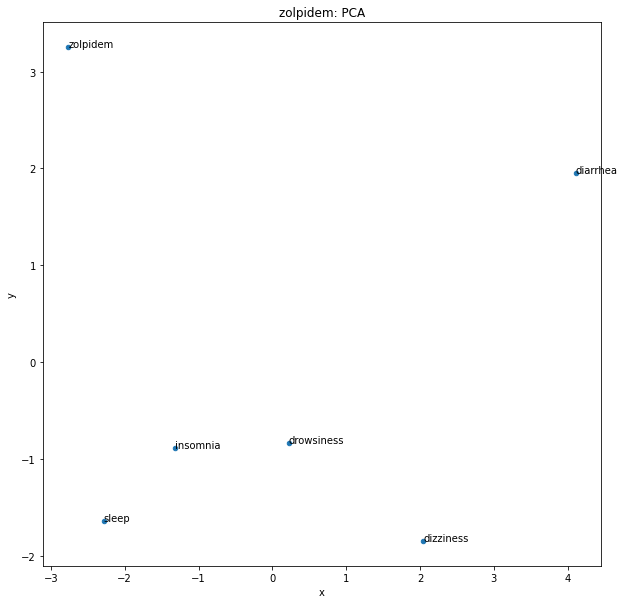

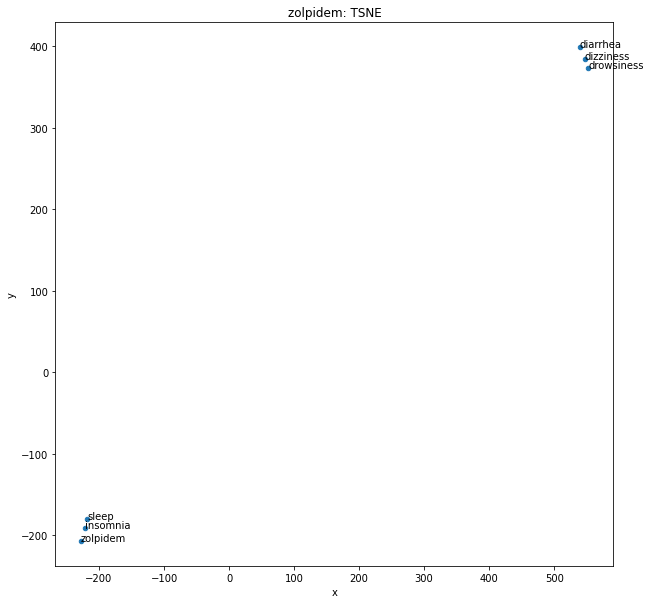

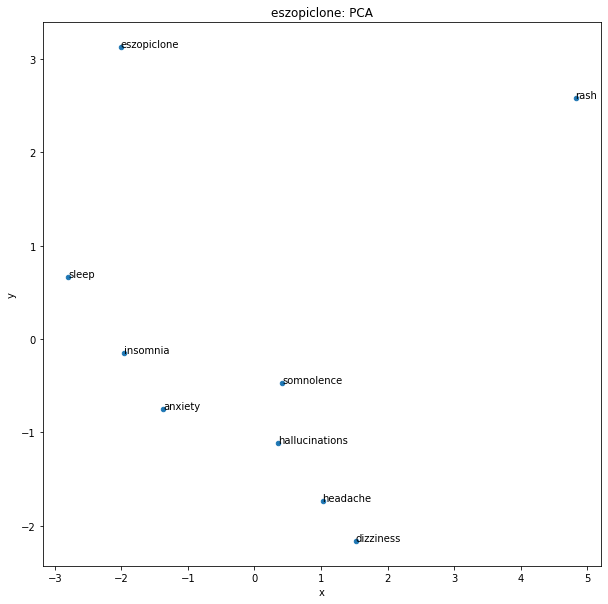

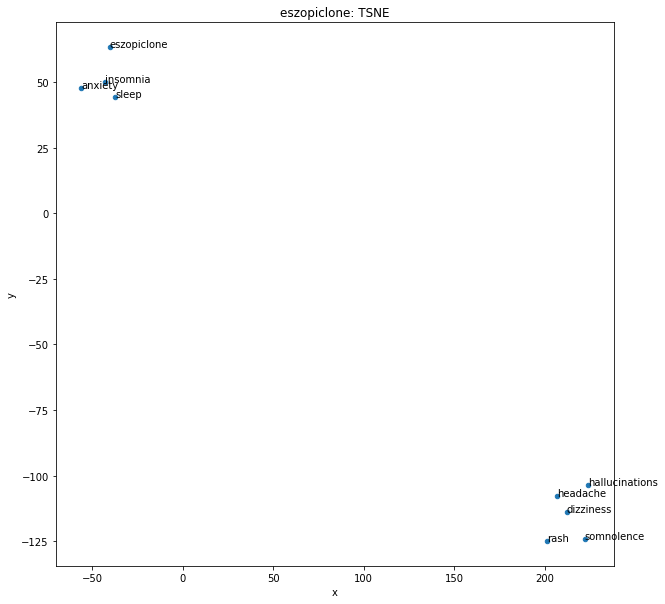

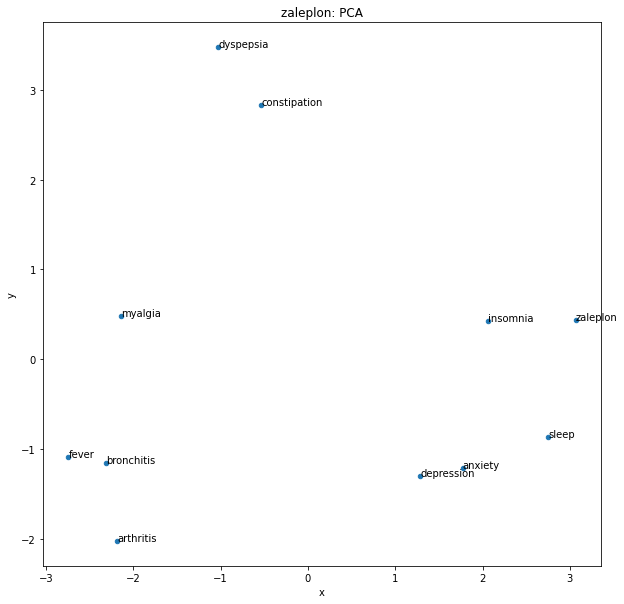

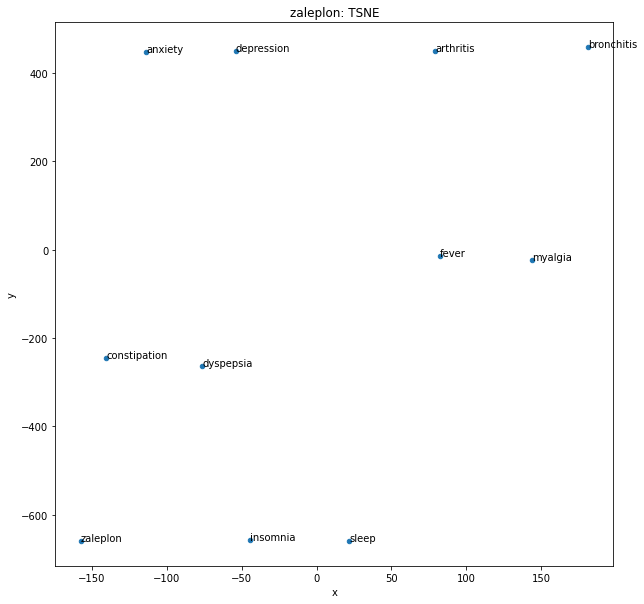

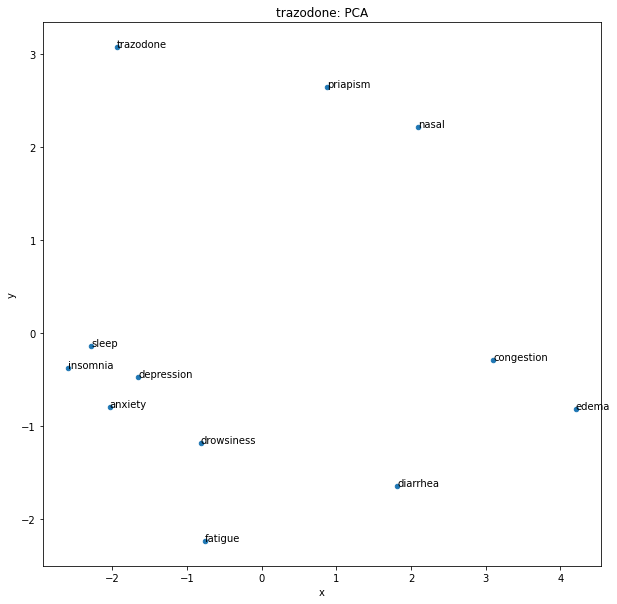

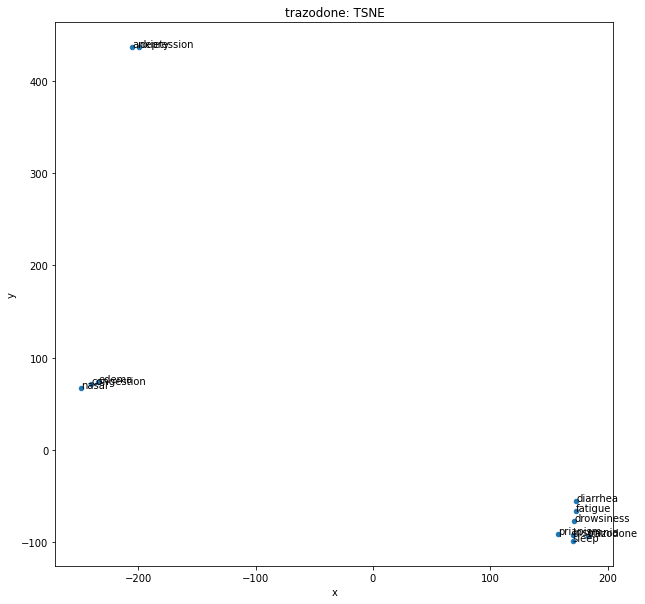

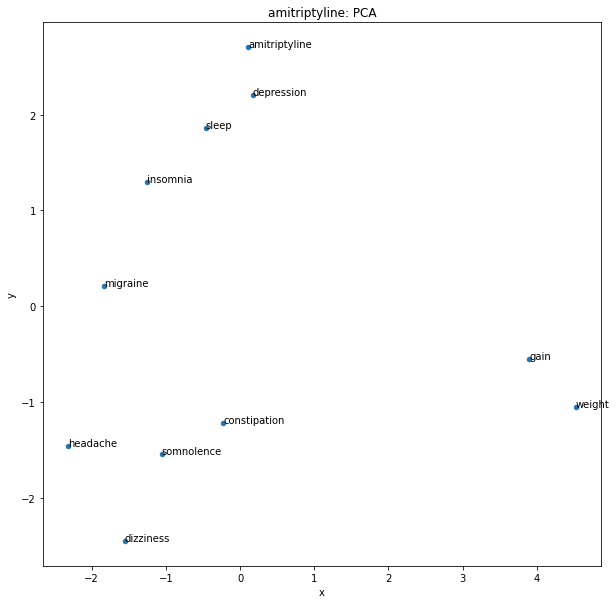

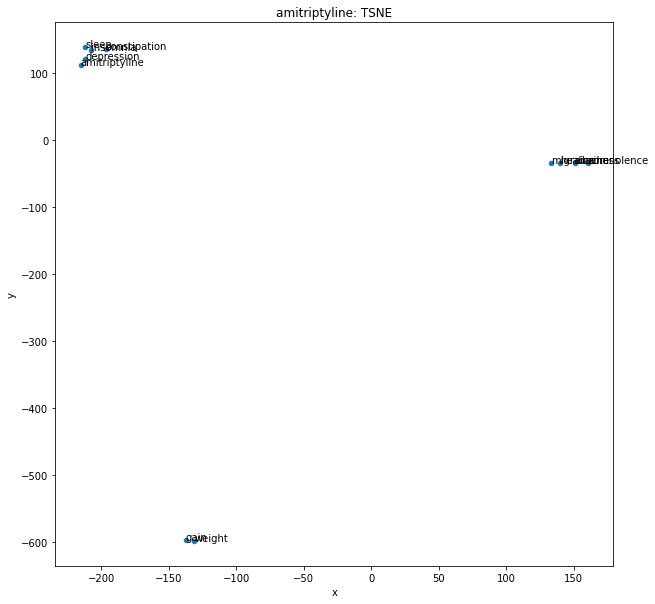

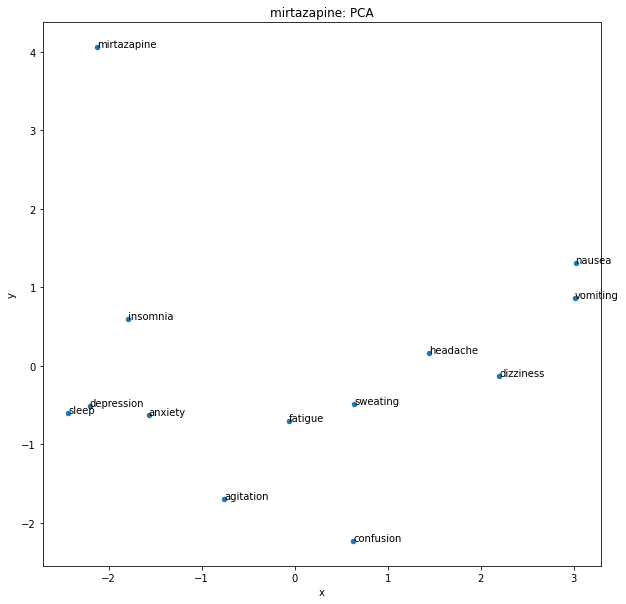

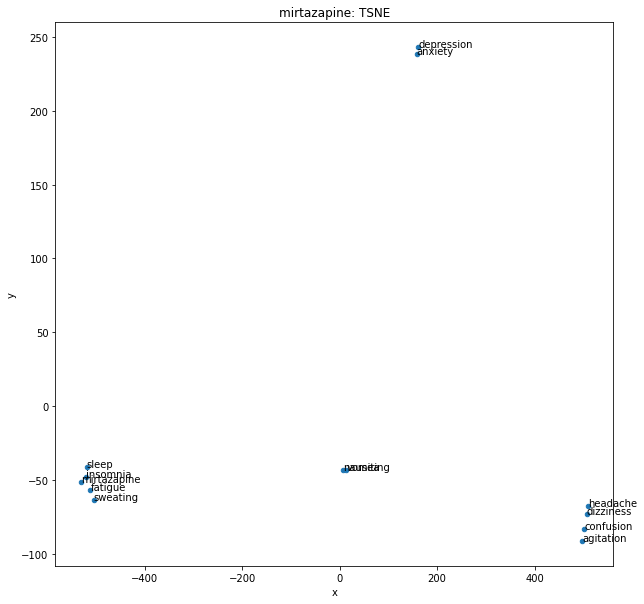

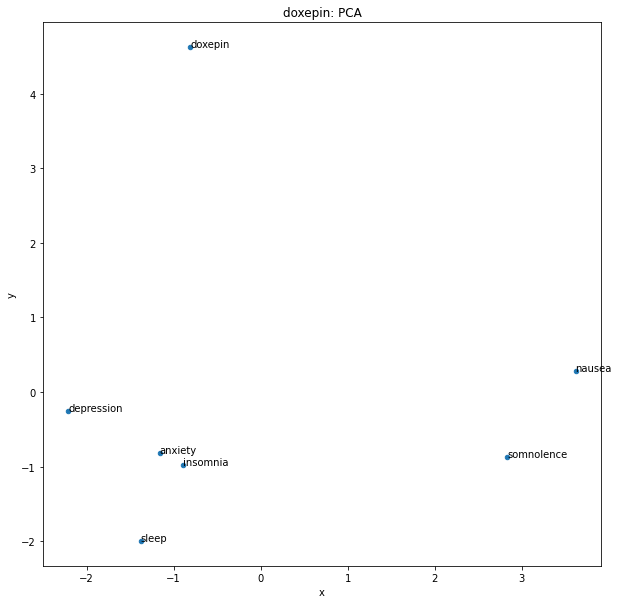

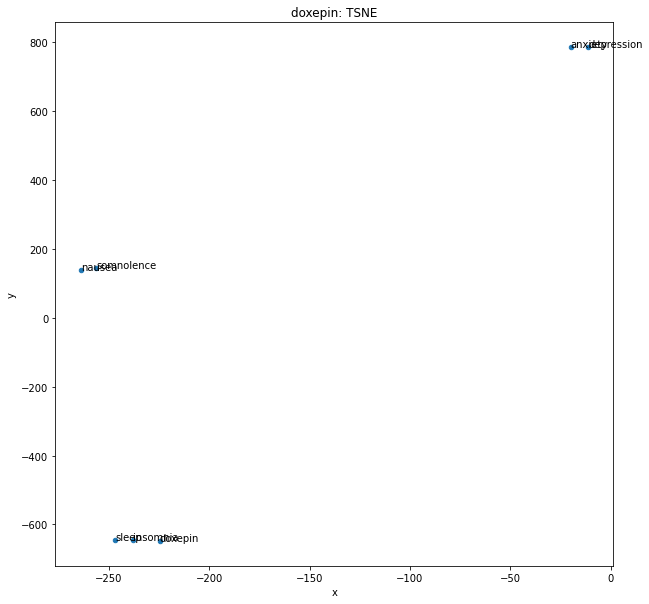

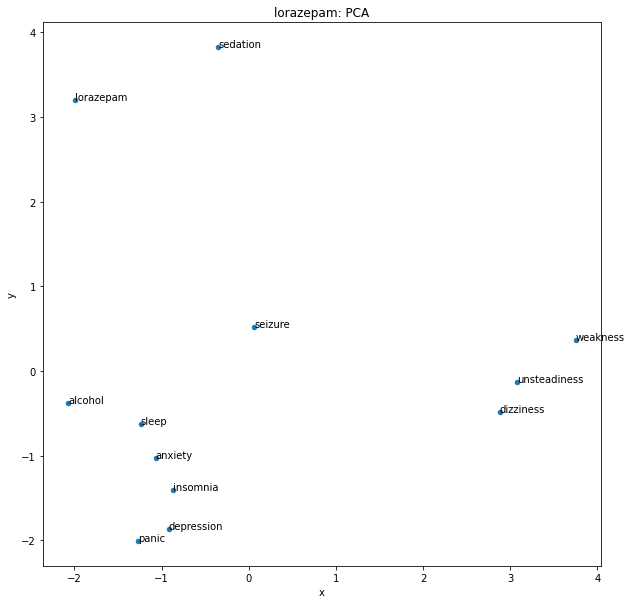

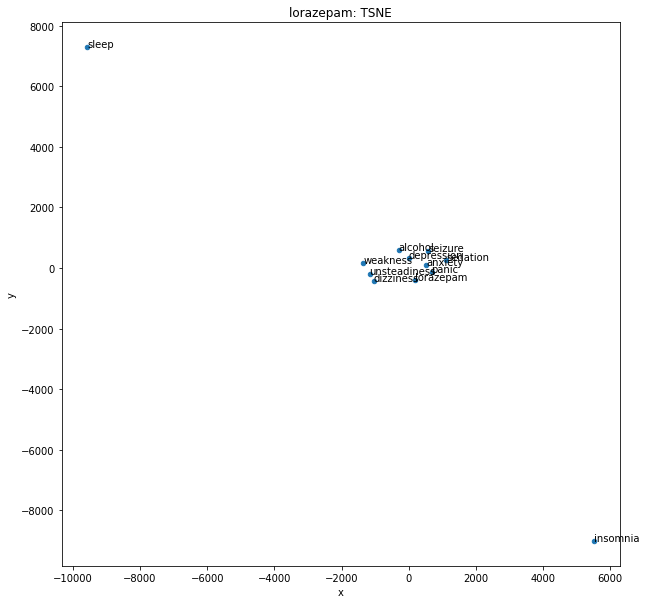

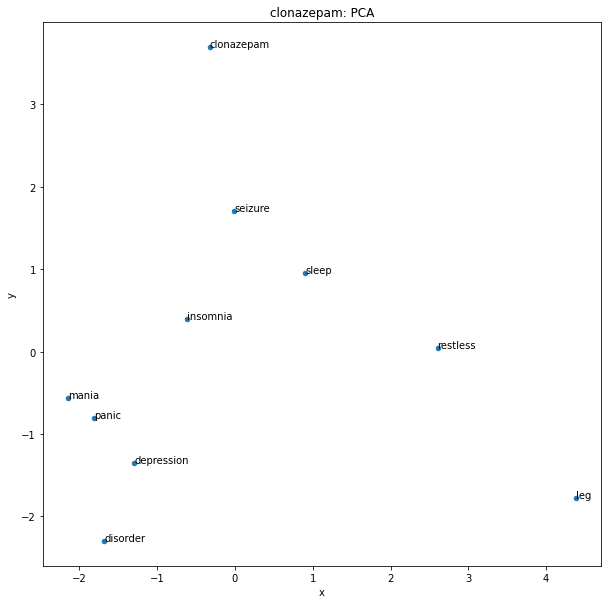

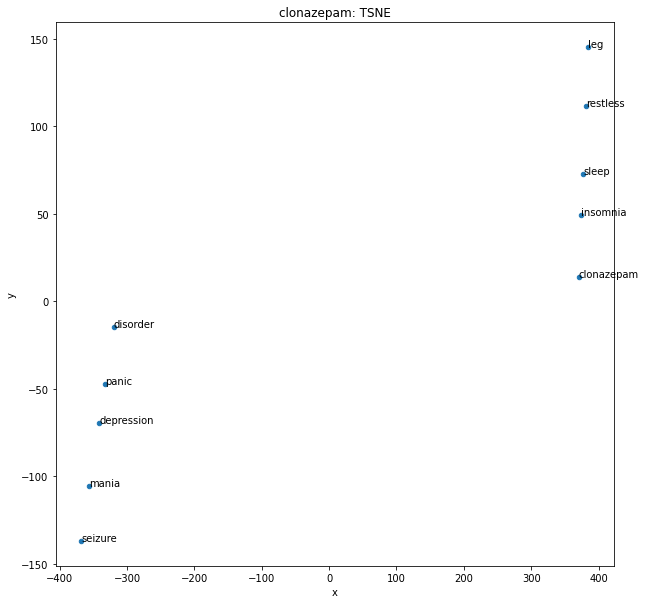

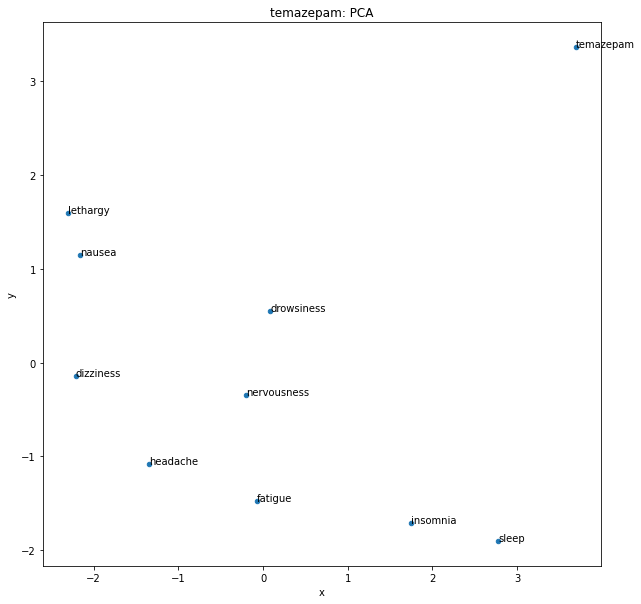

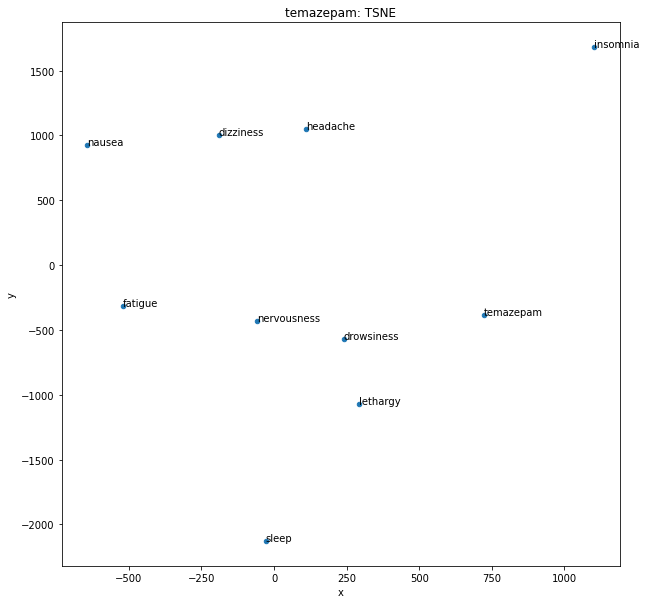

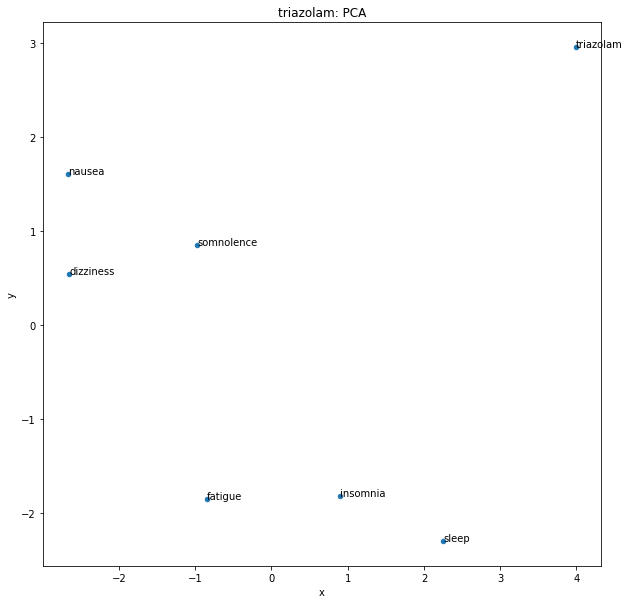

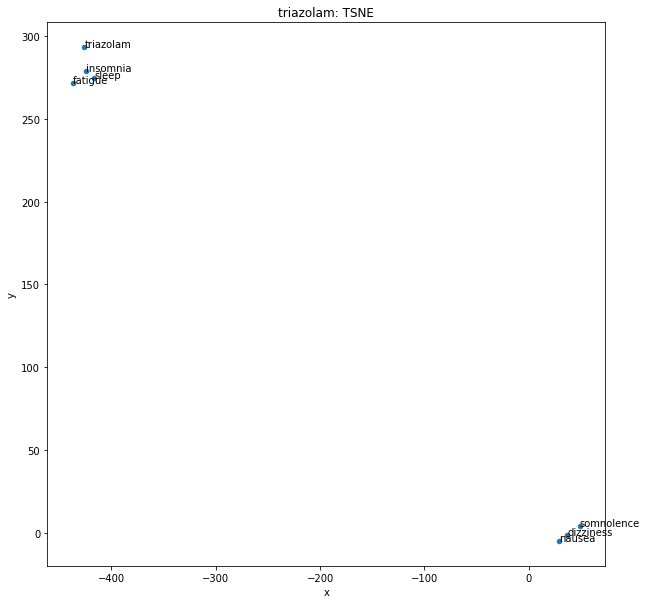

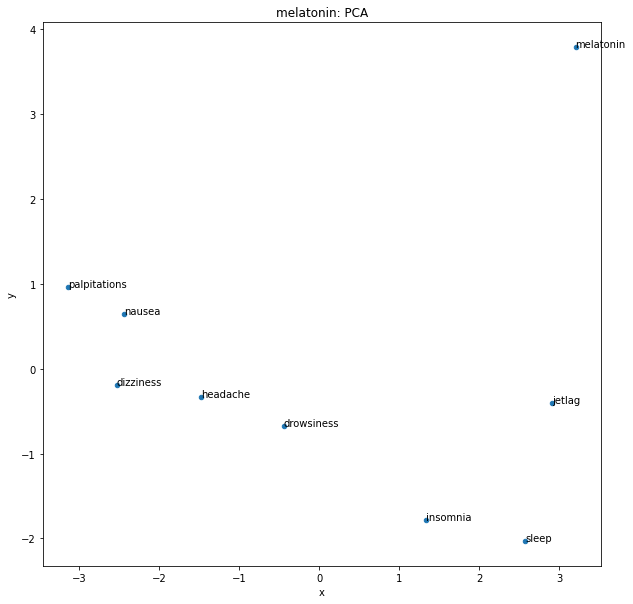

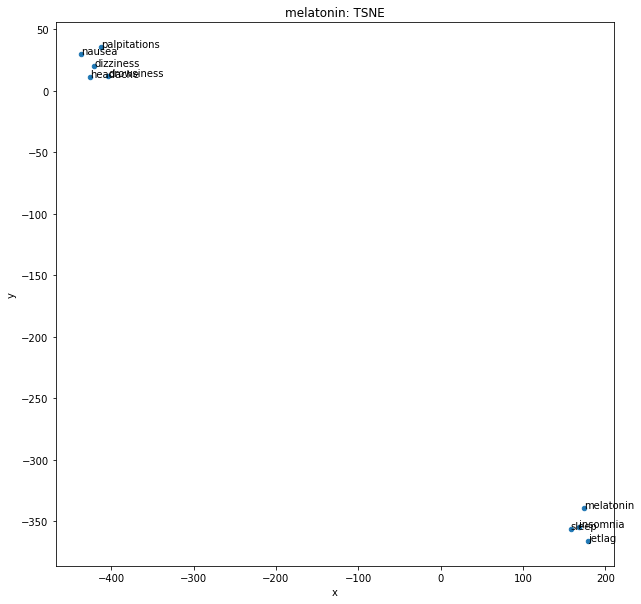

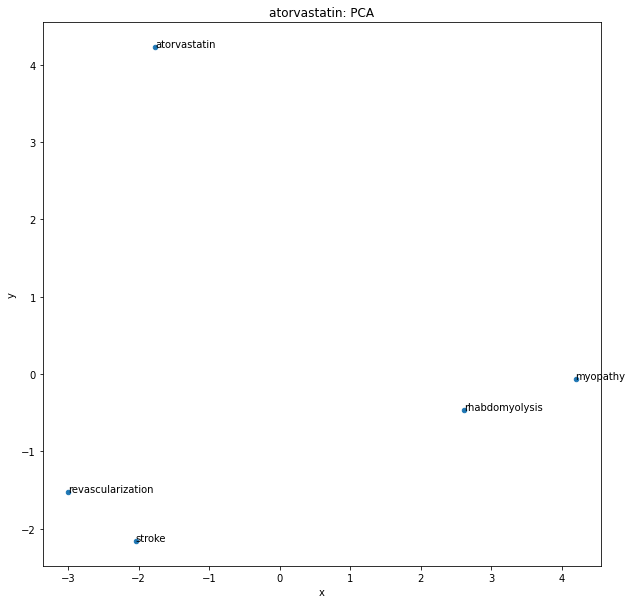

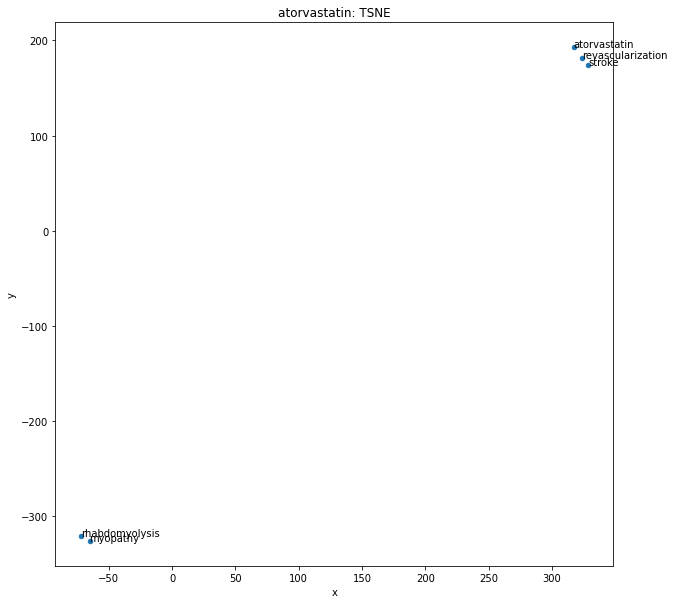

In [5]:
plot_insomnia_drugs()

In [6]:
get_similarity_table()

,name (zolpidem),similarity (zolpidem),name (eszopiclone),similarity (eszopiclone),name (zaleplon),similarity (zaleplon),name (trazodone),similarity (trazodone),name (amitriptyline),similarity (amitriptyline),...,name (clonazepam),similarity (clonazepam),name (temazepam),similarity (temazepam),name (triazolam),similarity (triazolam),name (melatonin),similarity (melatonin),name (atorvastatin),similarity (atorvastatin)
0,*zolpidem,0.967363,eszopiclone's,0.942277,zaleplone,0.943367,*trazodone,0.956025,amitriptylin,0.959679,...,*clonazepam,0.968582,s-temazepam,0.934742,miazolam,0.911035,ofmelatonin,0.941908,torvastatin,0.967771
1,zolpidem-,0.925903,-zopiclone,0.902447,zopiclone,0.868204,rrazodone,0.946647,amitriptyline+nortriptyline,0.959440,...,clonazepame,0.957945,-temazepam,0.925561,triazolam-,0.903398,melatonin/melatonin,0.929656,*atorvastatin,0.963377
2,-zolpidem,0.920687,zopiclone,0.902225,zopiclon,0.858176,trazodone/,0.934284,amitriptyline's,0.944972,...,meclonazepam,0.940150,temazepam's,0.919271,nazolam,0.900881,melatonin-a,0.924177,atorvastatine,0.961868
3,zopiclone/zolpidem,0.919021,r-zopiclone,0.898403,zolpidem,0.851964,o/n-trazodone,0.924398,butriptyline,0.941445,...,clonazepam's,0.939033,premazepam,0.904411,triazolam's,0.899569,melatonine,0.924059,2.atorvastatin,0.957953
4,zolpidem-er,0.917667,s-zopiclone,0.889498,zopiclone/zolpidem,0.836647,7.trazodone,0.922897,amitriptyline/nortriptyline,0.934908,...,-clonazepam,0.937775,oxazepam,0.901140,alprazolam,0.881076,melatonins,0.898755,+atorvastatin,0.954699
5,zolpidem-mr,0.911355,d-zopiclone,0.873684,zopiclone's,0.835820,-trazodone,0.905108,amitriptyline-,0.931882,...,klonazepam,0.937473,tazepam,0.896064,triazolam-lever,0.867495,no/melatonin,0.897171,ezetimibe+atorvastatin,0.952953
6,zolpidem's,0.910981,zopiclone/zolpidem,0.865192,quazepam,0.833256,trazodone's,0.896182,-amitriptyline,0.926768,...,chlonazepam,0.923377,clorazepam,0.893713,brotizolam,0.862709,/melatonin,0.895910,simvastatin/atorvastatin,0.951448
7,zolpidem-ir,0.901161,zopiclon,0.857775,lormetazepam,0.831810,d4-trazodone,0.894222,amitriptylinum,0.926483,...,clonazepam-,0.913957,larazepam,0.887753,estazolam,0.862285,melatonin/h,0.885899,simvastatin,0.944500
8,zolpidem5mg,0.894403,armodafinil,0.853582,-zopiclone,0.830344,mcpp/trazodone,0.894173,amitriptyline/haloperidol,0.924277,...,conazepam,0.905262,pentazepam,0.885659,non-triazolam,0.859938,sr-melatonin,0.884529,atorvastatin-ezetimibe,0.943374
9,zopiclone,0.877061,modafinil/armodafinil,0.851170,eszopiclone,0.828971,mirtazapine,0.884872,nortriptyline,0.924192,...,clonazepan,0.903497,loazepam,0.885451,zopiclone,0.856125,h-melatonin,0.883986,atorvastatin-niacin,0.939905


In [7]:
get_effects_table()

,name (zolpidem),similarity (zolpidem),name (eszopiclone),similarity (eszopiclone),name (zaleplon),similarity (zaleplon),name (trazodone),similarity (trazodone),name (amitriptyline),similarity (amitriptyline),...,name (clonazepam),similarity (clonazepam),name (temazepam),similarity (temazepam),name (triazolam),similarity (triazolam),name (melatonin),similarity (melatonin),name (atorvastatin),similarity (atorvastatin)
0,zolpidem-induced,0.598309,eszopiclone's,0.605634,zaleplon-induced,0.600395,trazodone's,0.611413,amitriptyline-induced,0.653893,...,chlordiazepoxide-induced,0.601985,s-temazepam,0.593832,triazolam's,0.628441,melatonin-induced,0.663698,atorvastatin-induced,0.652703
1,gaboxadol's,0.591002,eszopiclone-induced,0.595923,2-effects,0.577867,effect,0.599750,amitriptyline's,0.647353,...,effect,0.596794,chlordiazepoxide-induced,0.573152,triazolam-induced,0.624518,melatonin's,0.659568,fluvastatin-induced,0.648590
2,flurazepam-induced,0.580049,gaboxadol's,0.589398,zaleplone,0.572273,chlordiazepoxide-induced,0.594877,amitriptyline-mediated,0.643732,...,clonazepam-induced,0.593944,pentazepam,0.562233,2-effects,0.585415,melatonin-a,0.653544,atorvastatin's,0.644155
3,flunitrazepam-induced,0.577757,2-effects,0.562770,gaboxadol's,0.561396,trazodone-induced,0.590991,amitriptyline-evoked,0.618340,...,diazepam,0.584519,beta-effects,0.559174,beta-effects,0.582608,melatonin-elicited,0.648259,rosuvastatin-induced,0.641841
4,2-effects,0.575021,gaboxadol,0.562761,erp-effects,0.556184,amitriptyline-induced,0.589306,effect,0.615194,...,chlonazepam,0.578140,nitrazepam-induced,0.558631,chlordiazepoxide-induced,0.582400,melatonins,0.645642,simvastatin-induced,0.639468
5,zaleplon-induced,0.570152,effect,0.560940,effect,0.548655,amitriptyline's,0.585783,amitriptyline-like,0.613492,...,flurazepam-induced,0.576791,diazepam,0.555995,triazolamers,0.575771,melatonin-mediated,0.643791,atorvastatin-mediated,0.634672
6,nitrazepam-induced,0.568244,zopiclone's,0.551252,e-effects,0.544295,effects.5,0.582114,amitriptylin,0.611795,...,clobazam-induced,0.575975,oxazepam,0.555567,triazolam-dependent,0.573874,melatonin-modulated,0.643628,fluvastatin's,0.634076
7,alpidem,0.566256,zaleplon-induced,0.549063,effects.3,0.544082,fluvoxamine's,0.578494,amitriptylinoxide,0.609800,...,anticonvulsant-like,0.572436,sulazepam,0.555446,effect,0.570646,melatonin-enhanced,0.642740,simvastatin's,0.633657
8,*zolpidem,0.565073,d-zopiclone,0.545944,effectsof,0.542336,buspirone's,0.577412,nortriptyline-induced,0.608549,...,effects.5,0.572239,oxazepam-induced,0.555134,concentration-effects,0.569827,melatonin-derived,0.642403,pitavastatin-induced,0.632841
9,chlordiazepoxide-induced,0.564695,armodafinil-induced,0.545855,beta-effects,0.537741,amitriptyline-mediated,0.575511,protriptyline-induced,0.605273,...,nitrazepam-induced,0.567377,nitrazepam,0.554290,alpha-effects,0.568629,ofmelatonin,0.639828,pravastatin-induced,0.623996


In [8]:
tmp_df = get_similarity_table(1000)
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/biowordvec_similarity.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  tmp_df.to_csv(f)




Mounted at /content/drive


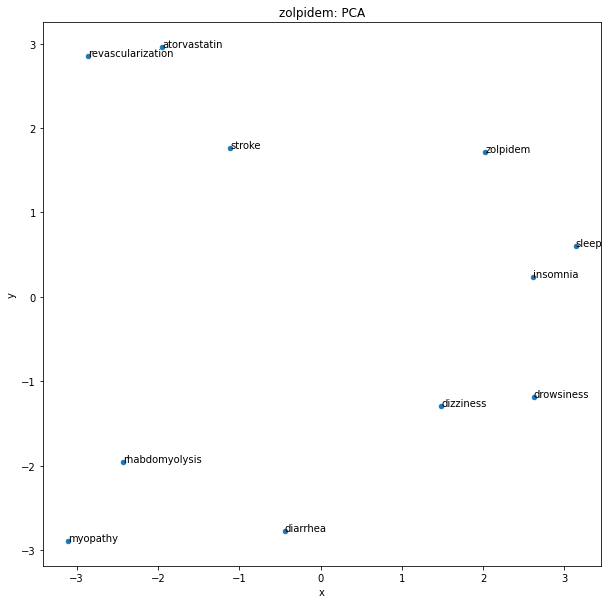

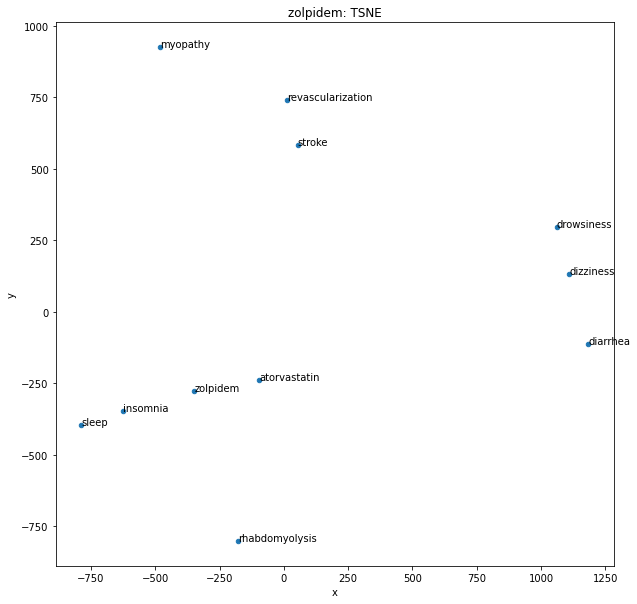

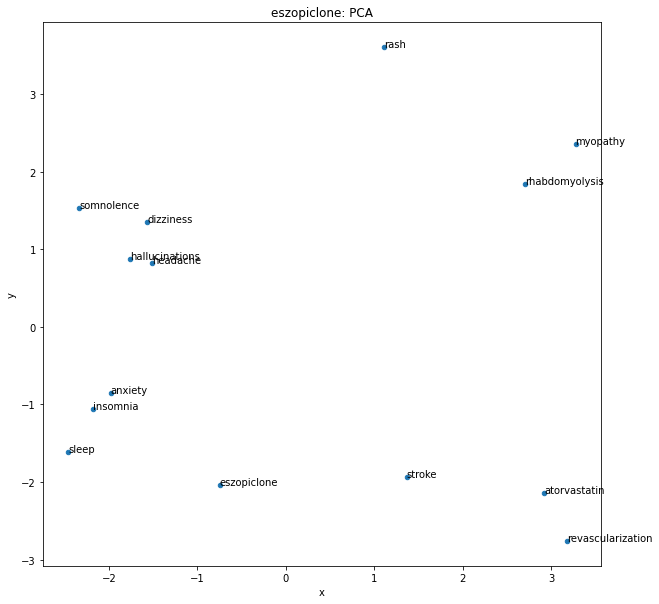

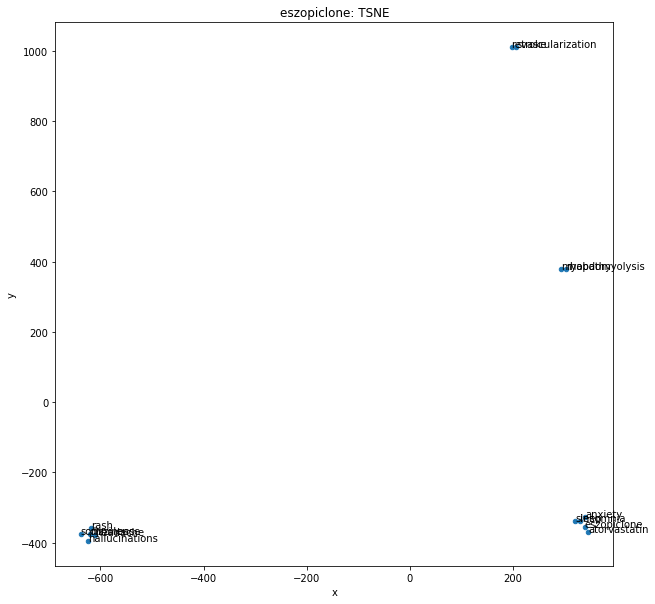

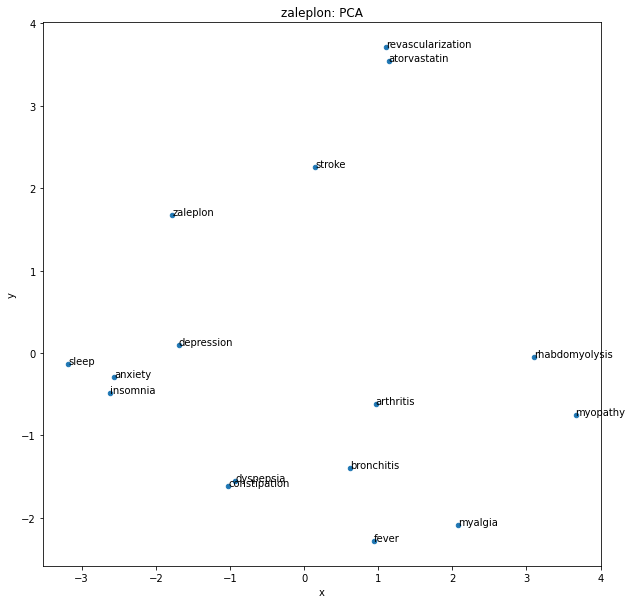

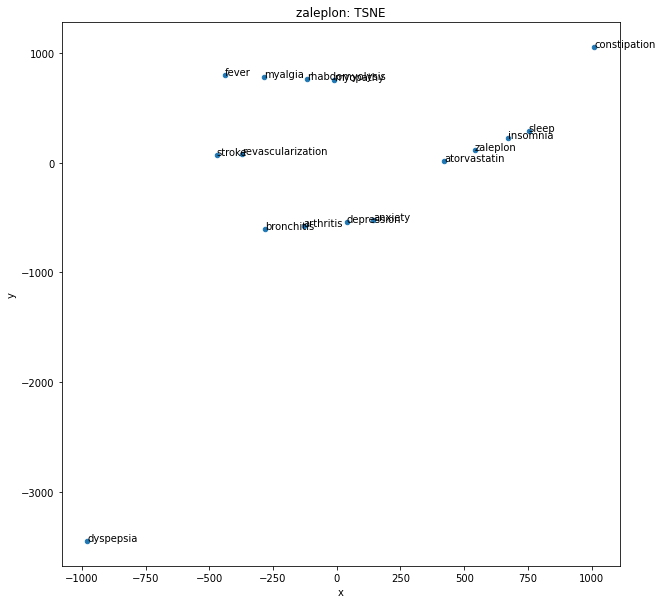

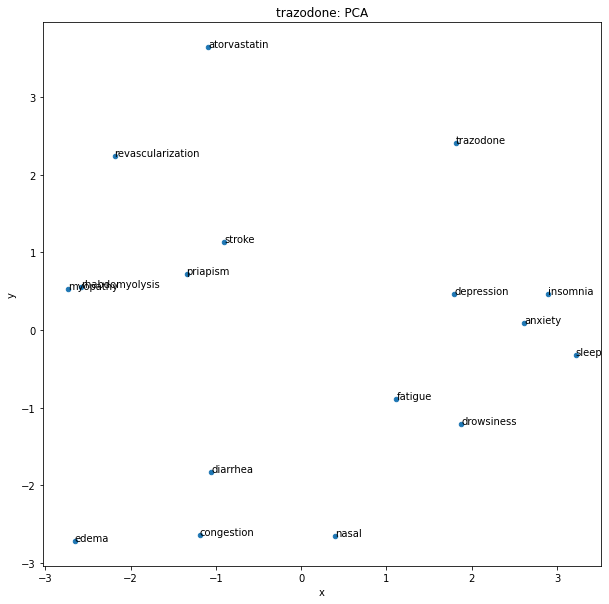

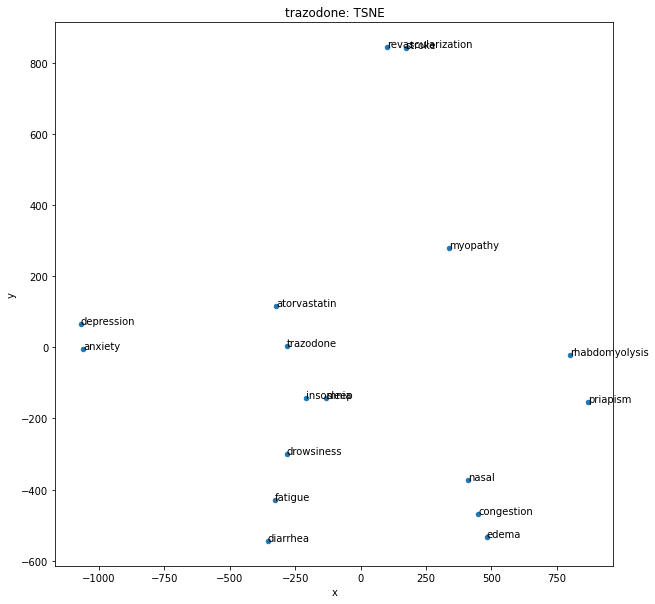

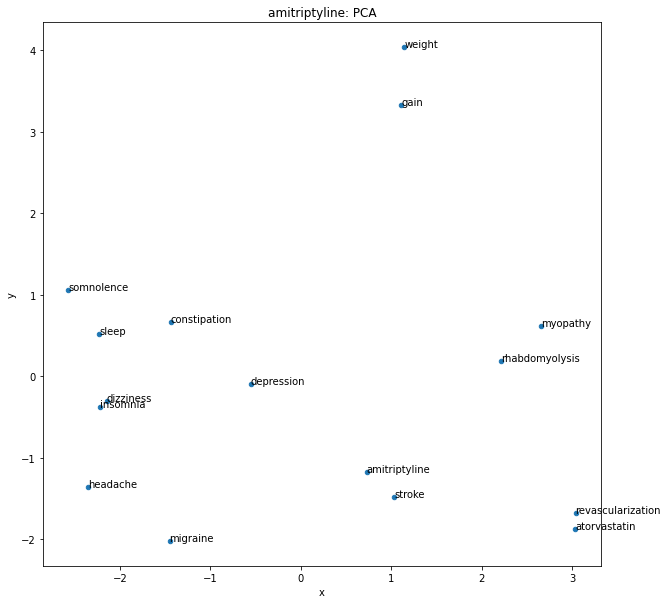

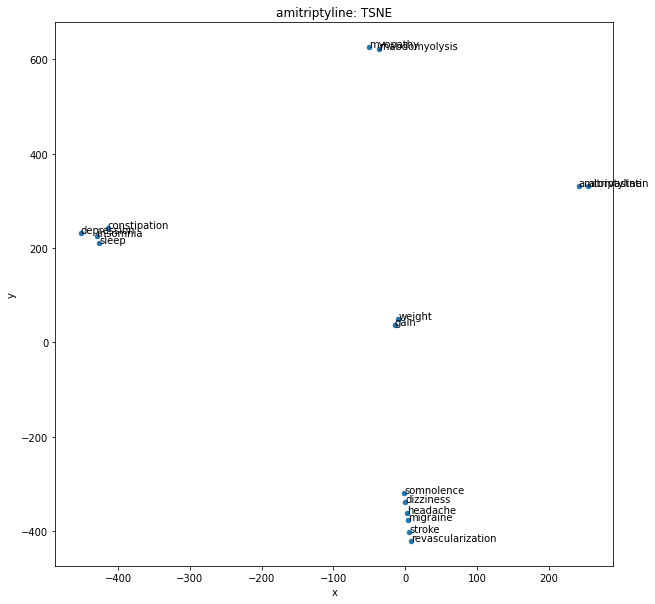

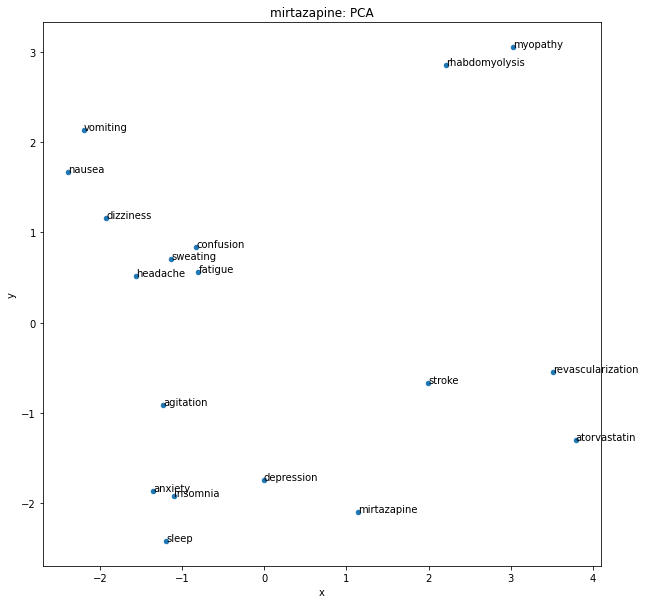

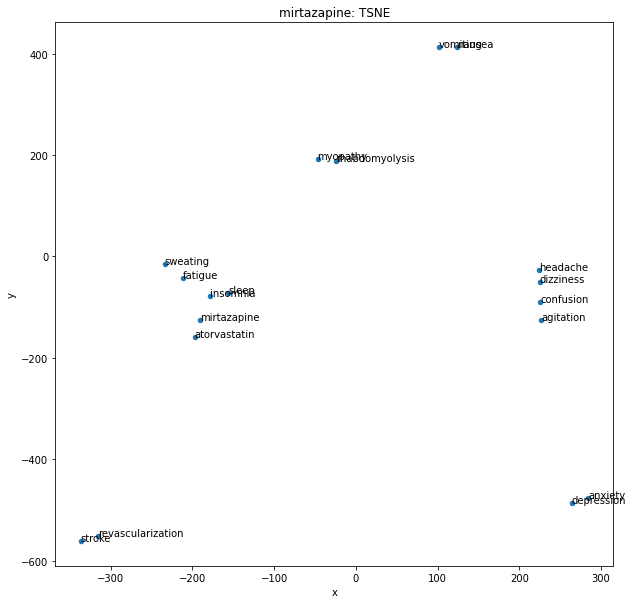

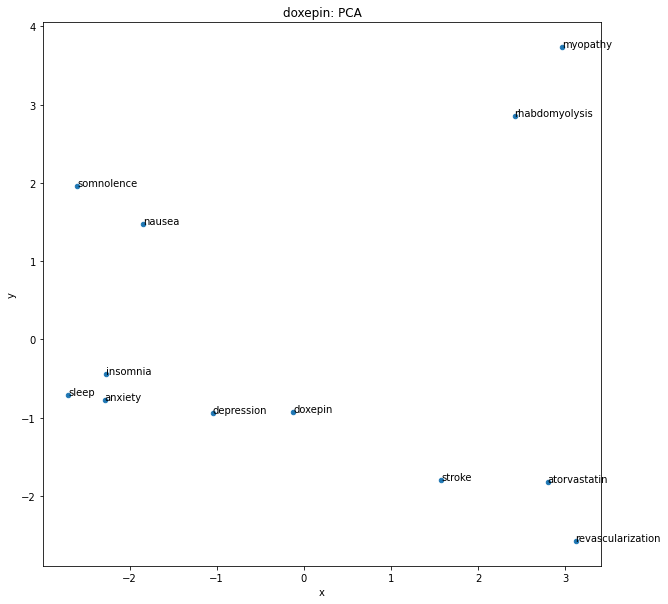

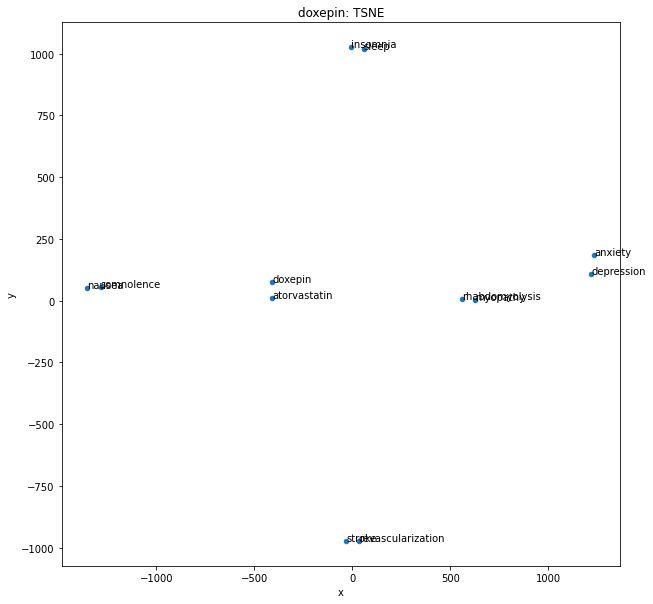

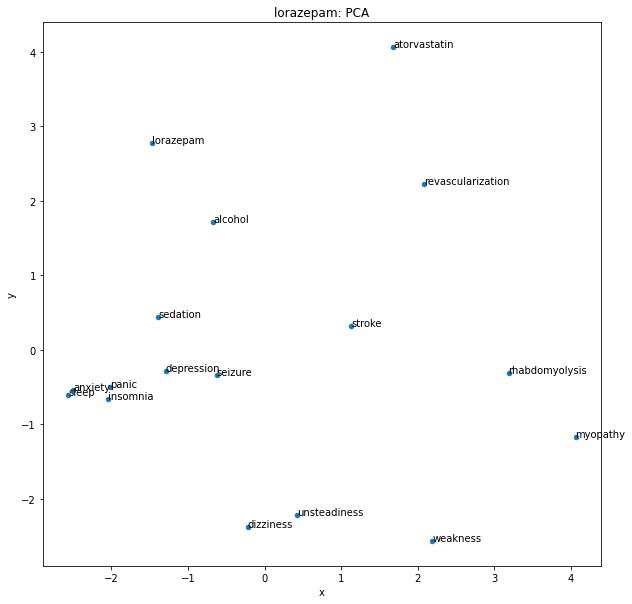

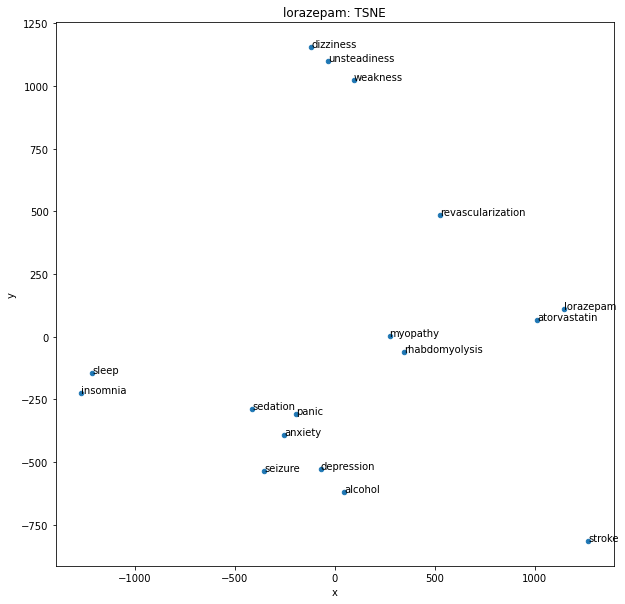

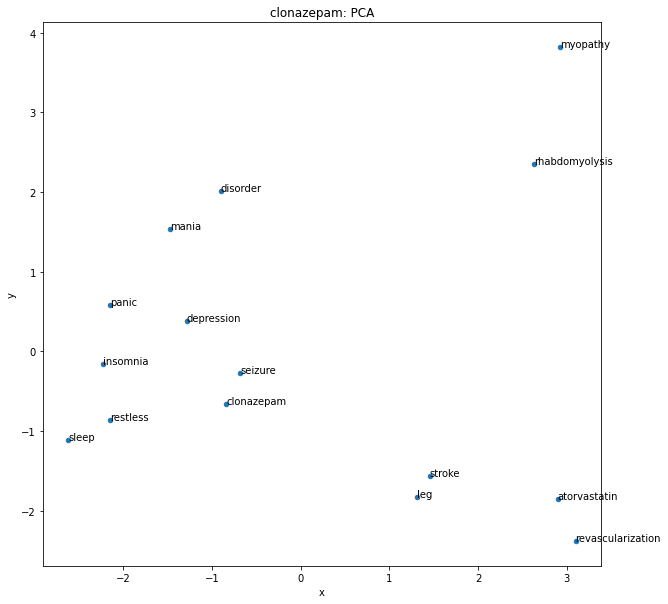

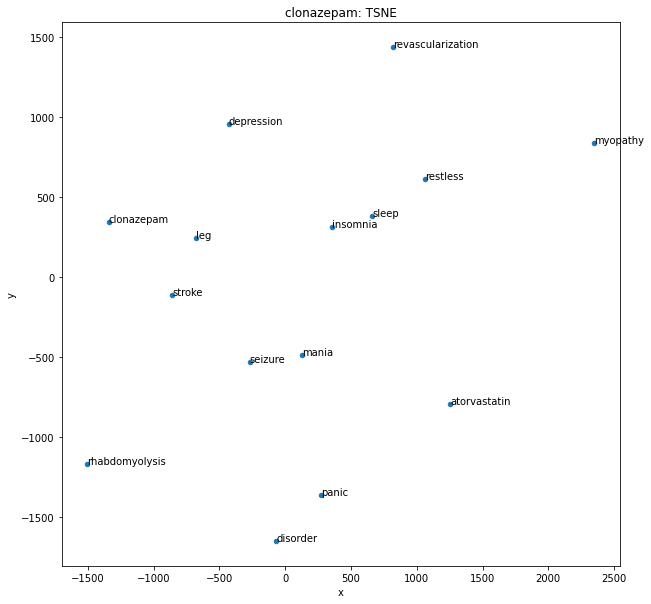

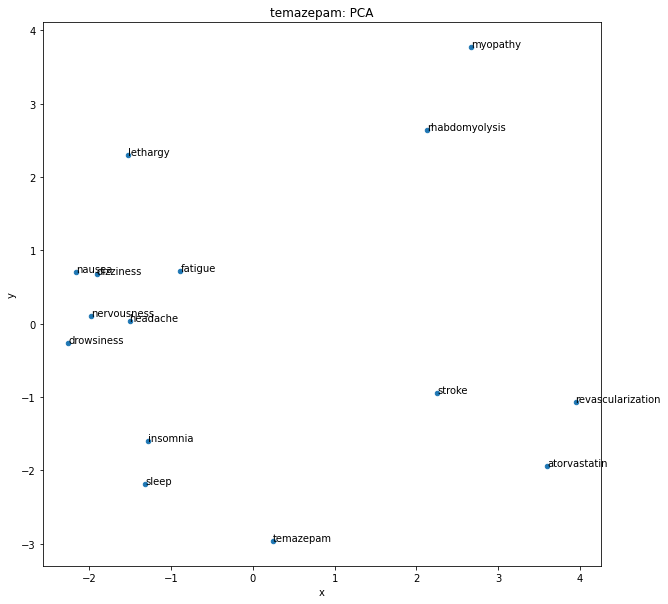

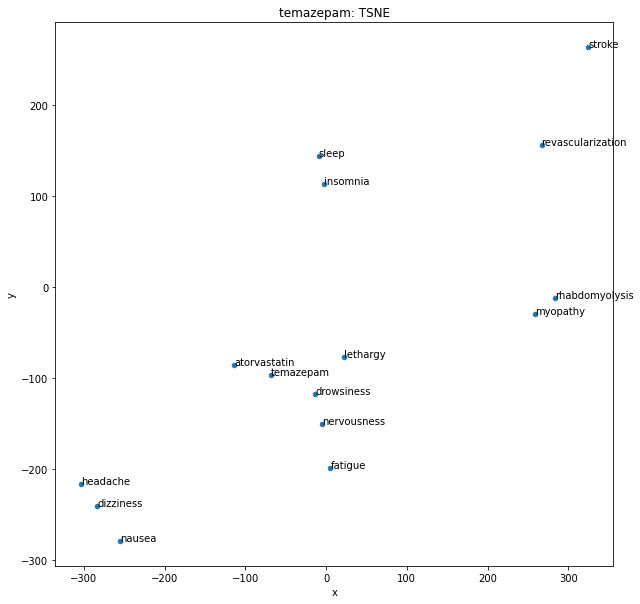

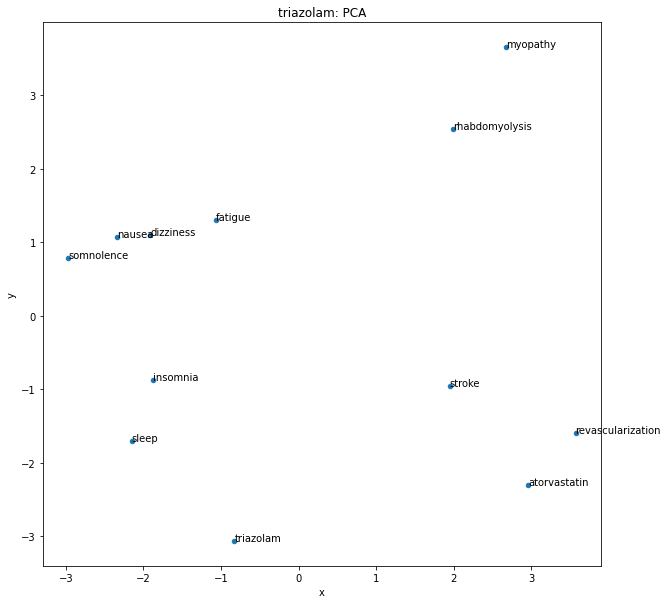

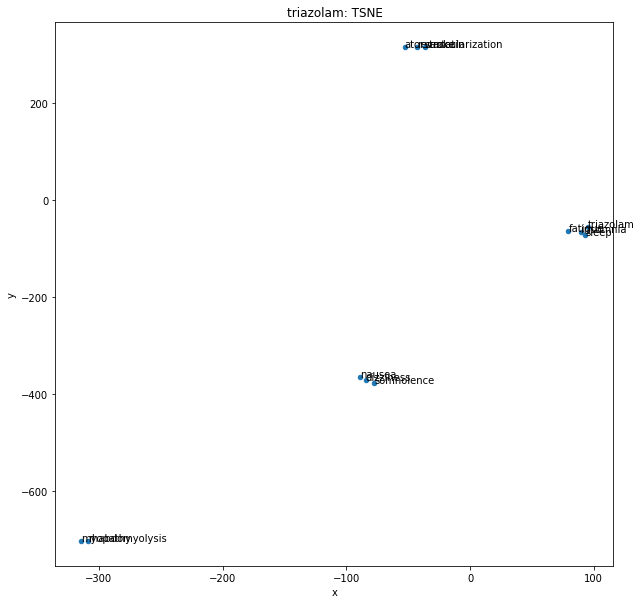

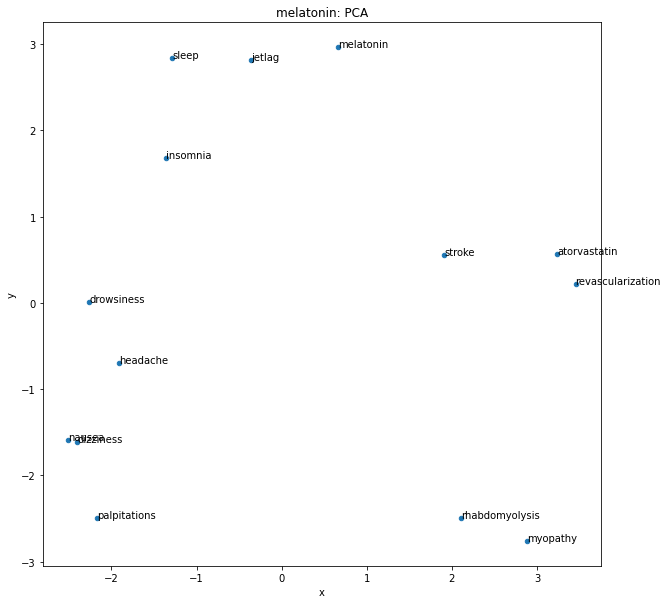

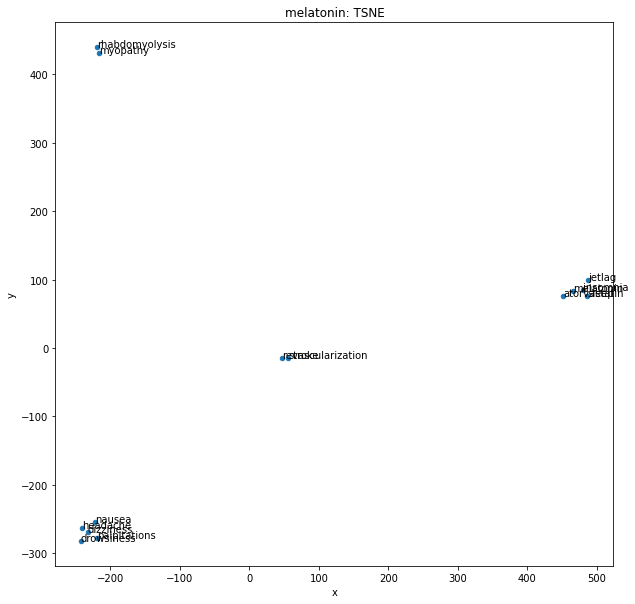

In [9]:
# sensitivity

new_url = "https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects-4.csv"
new_df = pd.read_csv(new_url, header=None, error_bad_lines=False)
insomnia_drug_names2 = new_df[0].tolist()
ind_dct2 = {k: v for v, k in enumerate(insomnia_drug_names2)}

def get_words2(drug_name):
  return [incom for incom in new_df.iloc[ind_dct2[drug_name]] if str(incom) != 'nan']

def plot_with_labels2(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words2(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  title_str = drug_name + (": PCA" if pca else ": TSNE")
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

def plot_insomnia_drugs2():
  for drug in insomnia_drug_names2:
    plot_with_labels2(drug)
    plot_with_labels2(drug, False)

plot_insomnia_drugs2()

0     Text(-2.125305599676706, -0.021582376739308014...
1     Text(-1.3618271753290463, 0.5883204736175813, ...
2     Text(-2.0427269983823653, 1.010866064549647, '...
3     Text(-1.3895076099861319, -0.6553271424145191,...
4     Text(-0.49365997203242806, -0.4915797600830819...
5     Text(-1.0822071507006497, -0.852017587518988, ...
6     Text(-1.0107045483272832, -0.3556155336214189,...
7     Text(-1.9706407126406478, -1.8221726464269645,...
8     Text(-1.8971521708116512, -0.8050153885670889,...
9     Text(-2.0384252721799427, -0.5815017141159743,...
10    Text(-2.200418059771709, 0.7998772966059883, '...
11    Text(0.08060623651156272, 4.381455669508033, '...
12    Text(3.6049490773954926, -0.8600556552468435, ...
13    Text(3.6049490773954926, -0.8600556552468435, ...
14    Text(3.513639020442423, 0.3476626083312876, 'f...
15    Text(3.289169440603401, 0.6678982389885689, 'l...
16    Text(3.519262417490187, -0.4911568916200769, '...
dtype: object

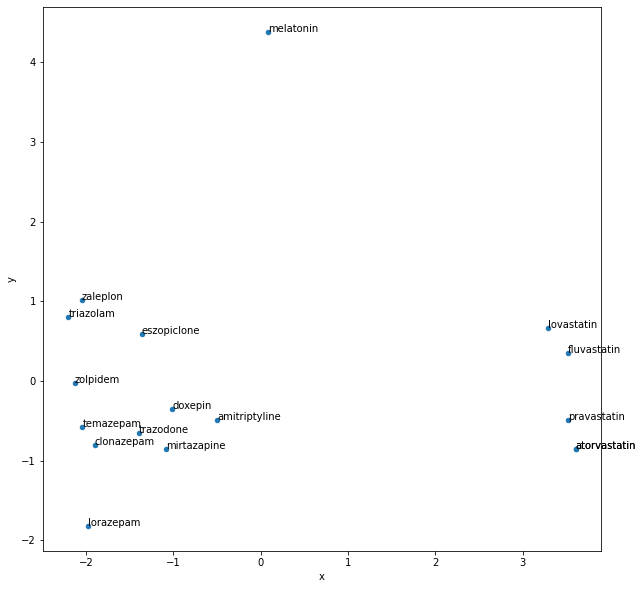

In [10]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_pca(embeddings_lst, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

0     Text(355.3213806152344, 54.143959045410156, 'z...
1     Text(271.3729248046875, -37.12588882446289, 'e...
2     Text(321.8009033203125, 17.879735946655273, 'z...
3     Text(-21.721345901489258, -527.7344360351562, ...
4     Text(-73.97389221191406, -106.86294555664062, ...
5     Text(-62.123924255371094, -501.988037109375, '...
6     Text(-66.08943939208984, -155.5985107421875, '...
7     Text(59.89277648925781, 370.7822570800781, 'lo...
8     Text(41.15987014770508, 324.99713134765625, 'c...
9     Text(90.14801025390625, 445.84100341796875, 't...
10    Text(115.80148315429688, 513.1273803710938, 't...
11    Text(-85.50182342529297, -33.161468505859375, ...
12    Text(767.9490966796875, -185.79811096191406, '...
13    Text(-355.8883361816406, -363.5767822265625, '...
14    Text(-455.14105224609375, 0.028204351663589478...
15    Text(-467.80462646484375, 73.66263580322266, '...
16    Text(-446.2892150878906, -48.562965393066406, ...
dtype: object

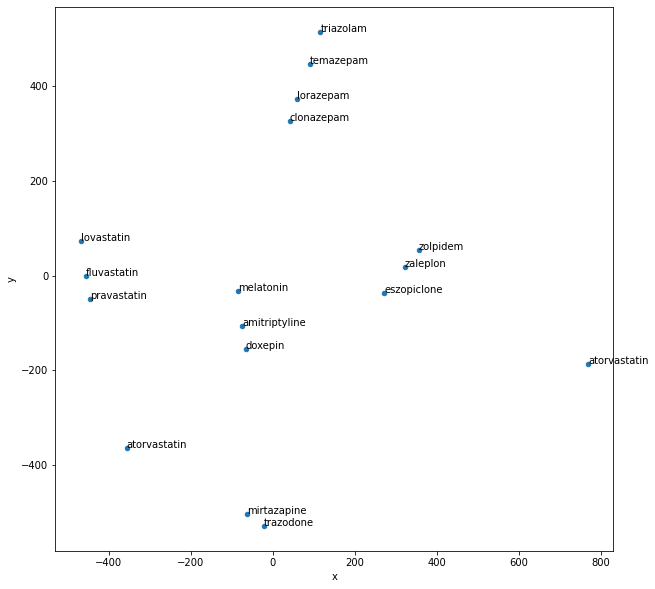

In [11]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

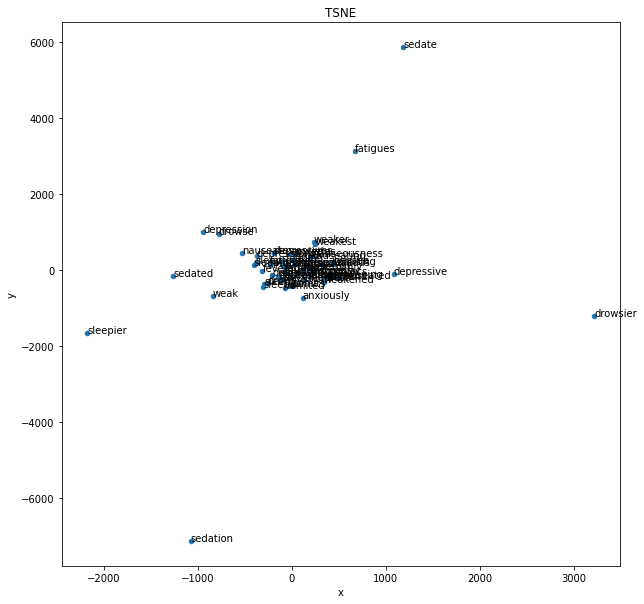

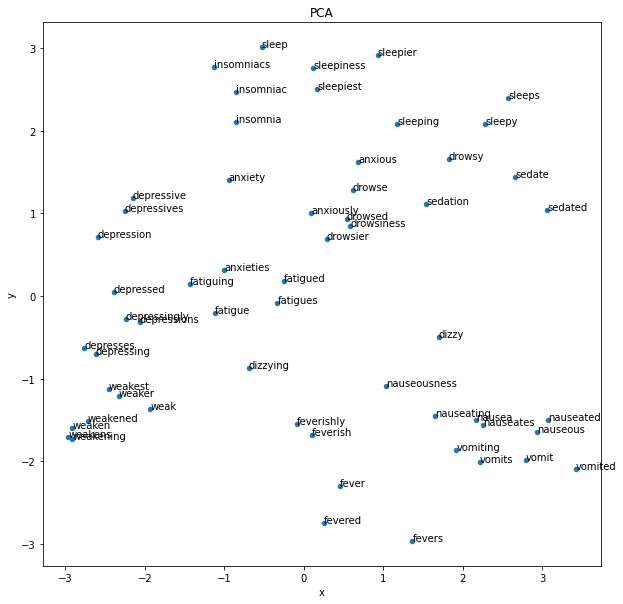

In [75]:
forms_of_words_analysis()